# Introduction



In [1]:
# Import local libraries
import joblib
import os
from tqdm import tqdm
import warnings

# Import 3rd party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle

# Functions

In [2]:
def look_for_pattern_in_NaN_tenure(data):
    """
    Prints descriptive statistics and value counts for specific columns in the given DataFrame
    where the 'Tenure' column has missing values.

    Parameters:
    - data: DataFrame
        The input DataFrame containing the data.

    Returns:
    None
    """
    temp_df = data[data['Tenure'].isna()]
    exclude = ['Tenure', 'RowNumber', 'CustomerId', 'Surname']
    describe = ['CreditScore', 'Age', 'Balance','EstimatedSalary']
    val_cnts = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
    for col in data.columns:
        if col in exclude:
            continue
        if col in describe:
            print(temp_df[col].describe())
        if col in val_cnts:
            print(temp_df[col].value_counts(dropna=False))
        print()


In [3]:
def get_f1_auc_roc_and_plot(model, random_state, features_train, target_train, features_valid, target_valid):
    """
    Calculate the F1 score, AUC-ROC score, and plot the ROC curve for a given model.

    Parameters:
    - model: The machine learning model to be used.
    - random_state: The random state for reproducibility.
    - features_train: The training features.
    - target_train: The training target.
    - features_valid: The validation features.
    - target_valid: The validation target.

    Returns:
    - f1: The F1 score.
    - auc_roc: The AUC-ROC score.
    """

    if model == LogisticRegression:
        model = model(random_state=random_state, solver='liblinear')
    else:
        model = model(random_state=random_state)
    
    model.fit(features_train, target_train)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]  # Use this for ROC

    f1 = f1_score(target_valid, model.predict(features_valid))
    auc_roc = roc_auc_score(target_valid, probabilities_valid)
    
    # Calculate the ROC curve from probabilities
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid)

    # Plot the ROC curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {model.__class__.__name__}')
    plt.legend()
    plt.show()

    print(f"F1 Score: {f1}")
    print(f"AUC-ROC Score: {auc_roc}")
    
    return f1, auc_roc


In [4]:
def load_results():
    """
    Load the results from a CSV file and return a DataFrame with reordered columns.

    Returns:
        results (DataFrame): DataFrame containing the loaded results with reordered columns.
    """
    pd.options.mode.chained_assignment = None  # default='warn' ignore the warning
    
    results = pd.read_csv('results/results.csv')
    
    # Add Model column
    results['model'] = None
    
    # Reorder the columns
    results = results[['f1_score', 'auc_roc', 'model', 'params', 'algorithm', 'method']]
    
    for i, row in results.iterrows():
        results['model'][i] = joblib.load(f'results/{i}.joblib')
        
    # Reset the warning
    pd.options.mode.chained_assignment = 'warn'
    
    return results

In [5]:
def update_results(results, df, balance_method):
    """
    Updates the results DataFrame with the provided DataFrame and balance method.

    Parameters:
    results (pandas.DataFrame): The existing results DataFrame.
    df (pandas.DataFrame): The DataFrame to be added to the results.
    balance_method (str): The balance method used for the DataFrame.

    Returns:
    pandas.DataFrame: The updated results DataFrame.
    """
    # Add the balance method to the DataFrame
    df['method'] = balance_method
    
    # Concatenate the results and the new DataFrame
    results = pd.concat([results, df], ignore_index=True)
    
    return results

In [6]:
def validate_DecisionTreeClassifier(features_train, target_train, features_valid, target_valid, random_state,
                                class_weight=[None],
                                max_depth=[None],
                                splitter=['best'],
                                criterion=['gini'],
                                min_samples_split=[2],
                                min_samples_leaf=[1],
                                max_features=[None]):
    """
    Validates the DecisionTreeClassifier model by testing different combinations of hyperparameters.
    
    Parameters:
    - features_train: The training features.
    - target_train: The training target.
    - features_valid: The validation features.
    - target_valid: The validation target.
    - random_state: The random state for reproducibility.
    - class_weight: The class weight for handling imbalanced data. Default is [None].
    - max_depth: The maximum depth of the tree. Default is [None].
    - splitter: The strategy used to choose the split at each node. Default is ['best'].
    - criterion: The function to measure the quality of a split. Default is ['gini'].
    - min_samples_split: The minimum number of samples required to split an internal node. Default is [2].
    - min_samples_leaf: The minimum number of samples required to be at a leaf node. Default is [1].
    - max_features: The number of features to consider when looking for the best split. Default is [None].
    
    Returns:
    - results: A DataFrame containing the f1_score, auc_roc, model, and params for the best model parameters.
    """
    
    results = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params'])
    
    # Calculate total number of iterations
    total = len(class_weight) * len(max_depth) * len(splitter) * len(criterion) * len(min_samples_split) * len(min_samples_leaf) * len(max_features)

    # Wrap the loop in tqdm to show a progress bar
    with tqdm(total=total, desc='Testing DecisionTreeClassifier Parameters', unit='iterations') as pbar:
        for cw in class_weight:
            for md in max_depth:
                for s in splitter:
                    for c in criterion:
                        for mss in min_samples_split:
                            for msl in min_samples_leaf:
                                for mf in max_features:
                                    # Save params in a dict
                                    params = {'class_weight': cw, 'max_depth': md, 'splitter': s, 'criterion': c, 'min_samples_split': mss, 'min_samples_leaf': msl, 'max_features': mf}
                                    
                                    # Define and train the model
                                    model = DecisionTreeClassifier(random_state=random_state, class_weight=cw, max_depth=md, splitter=s, criterion=c, min_samples_split=mss, min_samples_leaf=msl, max_features=mf)
                                    model.fit(features_train, target_train)
                                    score = model.score(features_valid, target_valid)
                                    
                                    # Score the model
                                    predictions_valid = model.predict(features_valid)
                                    f1 = f1_score(target_valid, predictions_valid)
                                    auc_roc = roc_auc_score(target_valid, predictions_valid)
                                    
                                    # Save the results
                                    new_row = pd.DataFrame({'f1_score': [f1], 'auc_roc': [auc_roc], 'algorithm': ['DecisionTreeClassifier'], 'params': [params], 'model': [model]})
                                    results = pd.concat([results, new_row], ignore_index=True)
                                    
                                    # Sort results by descending f1_score
                                    results = results.sort_values(by='f1_score', ascending=False)
                                    
                                    # Keep only top 3 results
                                    results = results.head(1)
                                    
                                    # Update the progress bar
                                    pbar.update(1)
                                    
    return results


In [7]:
def validate_RandomForrest(features_train, target_train, features_valid, target_valid,
                           class_weight=[None],
                           n_estimators=[50],
                           criterion=['gini'],
                           max_depth=[None],
                           min_samples_split=[2],
                           min_samples_leaf=[1],
                           max_features=['sqrt']):
    """
    Validates the Random Forest Classifier by testing different combinations of hyperparameters.
    
    Parameters:
    - features_train: The training features.
    - target_train: The training target.
    - features_valid: The validation features.
    - target_valid: The validation target.
    - class_weight: The class weight parameter for the Random Forest Classifier. Default is [None].
    - n_estimators: The number of trees in the forest for the Random Forest Classifier. Default is [50].
    - criterion: The function to measure the quality of a split for the Random Forest Classifier. Default is ['gini'].
    - max_depth: The maximum depth of the tree for the Random Forest Classifier. Default is [None].
    - min_samples_split: The minimum number of samples required to split an internal node for the Random Forest Classifier. Default is [2].
    - min_samples_leaf: The minimum number of samples required to be at a leaf node for the Random Forest Classifier. Default is [1].
    - max_features: The number of features to consider when looking for the best split for the Random Forest Classifier. Default is ['sqrt'].
    
    Returns:
    - results: A DataFrame containing the results of the validation, including f1_score, auc_roc, model, and params for the best model parameters.
    """
    
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params'])
    
    # Define the total for the progress bar
    total = len(class_weight) * len(n_estimators) * len(criterion) * len(max_depth) * len(min_samples_split) * len(min_samples_leaf) * len(max_features)
    # Initialize the progress bar
    with tqdm(total=total, desc='Testing RandomForestClassifier Parameters', unit='iterations') as pbar:
        for cw in class_weight:
            for ne in n_estimators:
                for c in criterion:
                    for md in max_depth:
                        for mss in min_samples_split:
                            for msl in min_samples_leaf:
                                for mf in max_features:
                                    # Save params in a dict
                                    params = {'class_weight': cw, 'n_estimators': ne, 'criterion': c, 'max_depth': md, 'min_samples_split': mss, 'min_samples_leaf': msl, 'max_features': mf,}
                                    # Define and train the model
                                    model = RandomForestClassifier(random_state=random_state, class_weight=cw, n_estimators=ne, criterion=c, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, max_features=mf)
                                    model.fit(features_train, target_train)
                                    # Score the model
                                    predictions_valid = model.predict(features_valid)
                                    f1 = f1_score(target_valid, predictions_valid)
                                    auc_roc = roc_auc_score(target_valid, predictions_valid)
                                    # Save the results
                                    new_row = pd.DataFrame({'f1_score': [f1], 'auc_roc': [auc_roc], 'algorithm': ['RandomForrestClassifier'], 'params': [params], 'model': [model]})
                                    results = pd.concat([results, new_row], ignore_index=True)
                                    # Sort results by descending f1_score
                                    results = results.sort_values(by='f1_score', ascending=False)
                                    # Keep only top 3 results
                                    results = results.head(1)
                                    # Update the progress bar
                                    pbar.update(1)
                                    
    return results

In [8]:
def validate_LogisticRegression(features_train, target_train, features_valid, target_valid, random_state,
                                class_weight=[None],
                                solvers=['liblinear'],
                                duals=[False],
                                penalties=['l2'],
                                max_iter=[100]):
    """
    Validates the Logistic Regression model with different parameter combinations.

    Parameters:
    - features_train (array-like): Training features.
    - target_train (array-like): Training target.
    - features_valid (array-like): Validation features.
    - target_valid (array-like): Validation target.
    - random_state (int): Random state for reproducibility.
    - class_weight (list, optional): List of class weights to consider. Defaults to [None].
    - solvers (list, optional): List of solvers to consider. Defaults to ['liblinear'].
    - duals (list, optional): List of dual values to consider. Defaults to [False].
    - penalties (list, optional): List of penalties to consider. Defaults to ['l2'].
    - max_iter (list, optional): List of maximum iterations to consider. Defaults to [100].

    Returns:
    - results (DataFrame): DataFrame containing the results of the validation process, including f1_score, auc_roc, model, and params for the best model parameters.

    """
    # Ignore ConvergenceWarning
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Ignore LineSearchWarning
    warnings.filterwarnings("ignore", message="^The line search algorithm did not converge")
    warnings.filterwarnings("ignore", message="^Line Search failed")
    
    # Create a DataFrame to store the results                                
    results = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params'])

    # Initialize the progress bar
    with tqdm(total=len(class_weight) * len(solvers) * len(duals) * len(penalties), desc='Testing LogisticRegression Parameters', unit='iterations') as pbar:
        for weight in class_weight:
            for solver in solvers:
                for dual in duals:
                    for penalty in penalties:
                        for iter in max_iter:

                            # Save params in a dict
                            params = {'class_weight': weight, 'solver': solver, 'dual': dual, 'penalty': penalty, 'max_iter': iter}
                            
                            # Define, train, and score the model
                            model = LogisticRegression(random_state=random_state, class_weight=weight, solver=solver, dual=dual, penalty=penalty)
                            try: # try/except to handle invalid param combinations
                                model.fit(features_train, target_train)
                                # Score the model
                                predictions_valid = model.predict(features_valid)
                                f1 = f1_score(target_valid, predictions_valid)
                                auc_roc = roc_auc_score(target_valid, predictions_valid)
                                # Save the results
                                new_row = pd.DataFrame({'f1_score': [f1], 'auc_roc': [auc_roc], 'algorithm': ['LogisticRegression'], 'params': [params], 'model': [model]})
                                results = pd.concat([results, new_row], ignore_index=True)
                                # Sort results by descending f1_score
                                results = results.sort_values(by='f1_score', ascending=False)
                                # Keep only top 3 results
                                results = results.head(1)
                                
                                # Update the progress bar
                                pbar.update(1)
                            except:
                                pbar.update(1)
                                continue

        return results

In [9]:
def save_results(results):
    """
    Save the results of the models to the 'results' directory.
    
    Parameters:
    results (DataFrame): The DataFrame containing the models and their corresponding results.
    
    Returns:
    None
    """
    
    if os.path.exists('results'):
        os.system('rm -rf results')
    
    os.mkdir('results')
    
    # Save each model from the results to the best_decision_tree directory
    for i, row in results.iterrows():
        joblib.dump(row['model'], f'results/{i}.joblib')
        
    # Drop the model column from the results
    results_temp = results.drop(columns='model')
    
    # Save the results to a csv file
    results_temp.to_csv('results/results.csv', index=False)

In [10]:
def upsample(features, target, repeat, random_state):
    """
    Upsamples the minority class (1) in a binary classification dataset.

    Parameters:
    - features (DataFrame): The feature matrix.
    - target (Series): The target variable.
    - repeat (int): The number of times to repeat the minority class samples.
    - random_state (int): The random seed for shuffling the upsampled data.

    Returns:
    - features_upsampled (DataFrame): The upsampled feature matrix.
    - target_upsampled (Series): The upsampled target variable.
    """

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state)

    return features_upsampled, target_upsampled

In [11]:
def downsample(features, target, fraction, random_state):
    """
    Downsamples the majority class (0) in a binary classification dataset.
    
    Parameters:
    - features (DataFrame): The feature matrix.
    - target (Series): The target variable.
    - fraction (float): The fraction of the majority class samples to keep.
    - random_state (int): The random seed for shuffling the downsampled data.
    
    Returns:
    - features_downsampled (DataFrame): The downsampled feature matrix.
    - target_downsampled (Series): The downsampled target variable.
    """
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=random_state)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=random_state)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=random_state)

    return features_downsampled, target_downsampled

In [12]:
def find_threshold(results, features_valid, target_valid):
    """
    Find the optimal threshold for binary classification models based on F1 score and AUC-ROC score.

    Parameters:
    - results (DataFrame): A DataFrame containing the results of different models.
    - features_valid (array-like): The features of the validation dataset.
    - target_valid (array-like): The target variable of the validation dataset.

    Returns:
    - temp_df (DataFrame): A DataFrame containing the top 3 results with the highest F1 score and AUC-ROC score.
    """

    # Create a df
    temp_df = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params', 'algorithm', 'method', 'threshold'])
    
    # For each row in the results
    for i, row in results.iterrows():
        # Define the model
        model = row['model']

        # Get the probabilities of the positive class
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
        
        # Test different thresholds
        for threshold in np.arange(0.0, 1.0, .02):
            # Convert probabilities to binary predictions
            predictions_valid = probabilities_one_valid > threshold
            # Calculate the f1 score
            f1 = f1_score(target_valid, predictions_valid)
            # Calculate the auc_roc score
            auc_roc = roc_auc_score(target_valid, predictions_valid)
            
            # Add the results to the temp_df
            temp_df = pd.concat([temp_df, pd.DataFrame({'f1_score': [f1], 'auc_roc': [auc_roc], 'model': [model], 'params': [row['params']], 'algorithm': [row['algorithm']], 'method': [row['method']], 'threshold': [threshold]})], ignore_index=True)
            
            # Sort the temp_df by descending f1_score, auc_roc
            temp_df = temp_df.sort_values(by=['f1_score', 'auc_roc'], ascending=False, ignore_index=True)
            
            # Keep only the top 3 results
            temp_df = temp_df.head(3)
            
    return temp_df

# Data Inspection and Cleaning

In [13]:
# Load the data
try: # If running locally
    data = pd.read_csv("Churn.csv")
except: # If running in the TripTen Environment
    data = pd.read_csv("/datasets/Churn.csv")

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [15]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [16]:
# Drop the RowNumber, and CustomerId columns since we will not want to use them as features in our model
data = data.drop(['RowNumber', 'CustomerId'], axis=1)

In [17]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [18]:
# Check for duplicates
data.duplicated().sum()

0

In [19]:
# Examine Tenure column
data['Tenure'].value_counts(dropna=False)

Tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64

We have 909 missing values in the Tenure column. Let's take a closer look to see if we might be able to find any pattern with these missing values.

In [20]:
look_for_pattern_in_NaN_tenure(data)

count    909.000000
mean     648.451045
std       99.079381
min      359.000000
25%      580.000000
50%      647.000000
75%      718.000000
max      850.000000
Name: CreditScore, dtype: float64

Geography
France     464
Spain      229
Germany    216
Name: count, dtype: int64

Gender
Male      483
Female    426
Name: count, dtype: int64

count    909.000000
mean      38.647965
std        9.785438
min       18.000000
25%       32.000000
50%       37.000000
75%       43.000000
max       92.000000
Name: Age, dtype: float64

count       909.000000
mean      76117.341474
std       63105.690715
min           0.000000
25%           0.000000
50%       96674.550000
75%      128554.980000
max      206663.750000
Name: Balance, dtype: float64

NumOfProducts
1    467
2    406
3     32
4      4
Name: count, dtype: int64

HasCrCard
1    646
0    263
Name: count, dtype: int64

IsActiveMember
1    464
0    445
Name: count, dtype: int64

count       909.000000
mean      99180.389373
std       56378.06376

I'm not seeing any clear patterns with the missing values in Tenure. I think the best approach will be to fill the missing values with median of the data set. We'll group by age, as that is probably a good indicator for account age.

In [21]:
# Get the median tenure for each group
data['Tenure'] = data['Tenure'].fillna(data.groupby('Age')['Tenure'].transform('median')) # Replaces the Tenure column with the median tenure for each group at the index level, then fills the NaN values with the median tenure for the group

# Median results in some floats, but all the original values are integers. So we will convert the Tenure column to integers (drops the decimal)
data['Tenure'] = data['Tenure'].astype(int)

In [22]:
# Re examine the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


Missing data in the tenure column has been handled. There are no other missing value issues. Columns unwanted for training the model have been dropped (Row number, and CustomerID). The Dtypes are already formatted in the optimal way for one hot encoding and feature scaling. 

# Examine the Balance of Target Data

In [23]:
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

There is a big imbalance in the data for the target variable. We'll start by training the model without regard to this imbalance, then train again accounting for the imbalance.

# Prepare Data for Training

In [24]:
# Transform the data with One Hot Encoding for categorical columns
data = pd.get_dummies(data, drop_first=True)

# Split the data into features and target
features = data.drop('Exited', axis=1)
target = data['Exited']

# Define a constant random state
random_state = 12345

# Split the data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=random_state, stratify=target) # Stratify the target to ensure that the proportion of the target is the same in the training and testing sets

# Split the test set into validation and test sets
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, test_size=0.5, random_state=random_state, stratify=target_test) # Stratify the target to ensure that the proportion of the target is the same in the validation and test sets

# Check the shapes of the data
print(f"features_train shape: {features_train.shape}")
print(f"target_train shape: {target_train.shape}")
print(f"features_valid shape: {features_valid.shape}")
print(f"target_valid shape: {target_valid.shape}")
print(f"features_test shape: {features_test.shape}")
print(f"target_test shape: {target_test.shape}")


features_train shape: (6000, 2942)
target_train shape: (6000,)
features_valid shape: (2000, 2942)
target_valid shape: (2000,)
features_test shape: (2000, 2942)
target_test shape: (2000,)


In [25]:
# Define columns for numerical scaling
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Initialize the scaler
scaler = StandardScaler()

# Tune the scaler on the training data
scaler.fit(features_train[numerical_columns])

# Scale the training, validation, and test data
features_train[numerical_columns] = scaler.transform(features_train[numerical_columns])
features_valid[numerical_columns] = scaler.transform(features_valid[numerical_columns])
features_test[numerical_columns] = scaler.transform(features_test[numerical_columns])


# Train Models without Regard to Imbalance

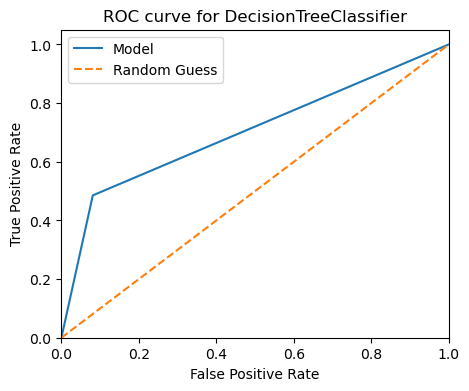

F1 Score: 0.5387755102040818
AUC-ROC Score: 0.702131983446645


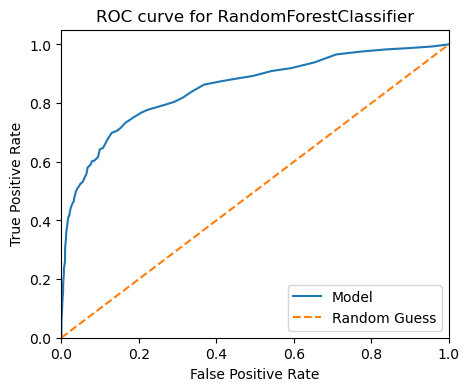

F1 Score: 0.555921052631579
AUC-ROC Score: 0.8515855934082174


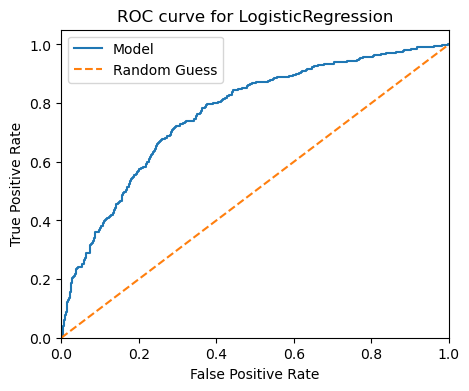

F1 Score: 0.325
AUC-ROC Score: 0.7658035890235491


In [26]:
get_f1_auc_roc_and_plot(DecisionTreeClassifier, random_state, features_train, target_train, features_valid, target_valid)
get_f1_auc_roc_and_plot(RandomForestClassifier, random_state, features_train, target_train, features_valid, target_valid)
get_f1_auc_roc_and_plot(LogisticRegression, random_state, features_train, target_train, features_valid, target_valid);

**ROC Curves and AUC Scores**

- **Decision Tree Classifier**: Exhibited a less smooth ROC curve, reflecting its binary, rule-based decision process. This resulted in an AUC-ROC score of 0.702, indicating moderate discrimination ability.
- **Random Forest Classifier**: Showed significant improvement over the Decision Tree, with a smoother ROC curve due to its ensemble nature, leading to better generalization. It achieved an AUC-ROC score of 0.852, indicating very good discrimination ability.
- **Logistic Regression**: Produced the smoothest ROC curve among the three, a characteristic of logistic regression’s probability-based nature. The AUC-ROC score was 0.766, showcasing good discrimination ability.

**F1 Scores**

- **Decision Tree Classifier**: Achieved an F1 score of 0.539, suggesting it struggles more with precision and recall balance.
- **Random Forest Classifier**: Achieved a slightly better F1 score of 0.556, reflecting its ability to better manage false positives and false negatives.
- **Logistic Regression**: Had the lowest F1 score of 0.325, indicating potential issues with either precision or recall, which could be attributed to the class imbalance.

**Conclusions**

Training without addressing class imbalance affects each model differently. The Random Forest model showed resilience, likely due to its method of averaging decisions across multiple trees which inherently reduces the variance and bias caused by imbalanced classes. In contrast, the Decision Tree and Logistic Regression models exhibited more sensitivity to the imbalance, impacting their F1 scores and ROC curves.

# Train Models with Regard to Imbalance



## Using the class_weight='balanced' argument

### DecisionTreeClassifier

In [27]:
results = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params', 'algorithm', 'method'])

In [28]:
# Ask if simple or deep tuning
if input('Would you like to perform deep tuning? (y, or any other key): ').lower() == 'y':

    decision_tree_params = {'max_depth': list(range(1, 21))+[None],
                            'splitter': ['best'],
                            'criterion': ['gini'],
                            'min_samples_split': [2],
                            'min_samples_leaf': [1, 2, 3],
                            'max_features': [None, 'sqrt']}

    random_forrest_params = {'n_estimators': list(range(100, 501, 100)),
                            'criterion': ['gini'],
                            'max_depth': [None],
                            'min_samples_split': [2],
                            'min_samples_leaf': [1, 2, 3],
                            'max_features': ['sqrt']}

    logistic_regression_params = {'duals': [False],
                                'penalties': ['l2'],
                                'solvers': ['liblinear'],
                                'max_iter': list(range(100, 501, 100))}
    
else: #Empty dictionaries for simple tuning
    decision_tree_params = {}
    random_forrest_params = {}
    logistic_regression_params = {}


In [29]:
results = update_results(results,
                            validate_DecisionTreeClassifier(features_train, target_train, features_valid, target_valid, random_state, class_weight=['balanced'], **decision_tree_params),
                            'balanced argument')

Testing DecisionTreeClassifier Parameters: 100%|██████████| 1/1 [00:00<00:00,  3.48iterations/s]


### RandomForrest

In [30]:
results = update_results(results, validate_RandomForrest(features_train, target_train, features_valid, target_valid,class_weight=['balanced'], **random_forrest_params), 'balanced argument')


Testing RandomForestClassifier Parameters: 100%|██████████| 1/1 [00:01<00:00,  1.88s/iterations]


### LogisticRegression

In [31]:
results = update_results(results, validate_LogisticRegression(features_train, target_train, features_valid, target_valid, random_state=random_state, class_weight=['balanced'], **logistic_regression_params), 'balanced argument')

Testing LogisticRegression Parameters: 100%|██████████| 1/1 [00:00<00:00,  6.26iterations/s]


In [32]:
display(results)

,f1_score,auc_roc,model,params,algorithm,method
0,0.559441,0.728163,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': None...",DecisionTreeClassifier,balanced argument
1,0.537217,0.689612,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': 'balanced', 'n_estimators': 5...",RandomForrestClassifier,balanced argument
2,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument


The Random Forrest Classifier continues to be the best performing algorithm for the task.

## Using Upsampling

In [33]:
print(target_train.value_counts())

Exited
0    4778
1    1222
Name: count, dtype: int64


In [34]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3, random_state)

print(target_upsampled.value_counts())

Exited
0    4778
1    3666
Name: count, dtype: int64


The minority class has been upsampled by 3x to maintain it as the minority class, while brining it into near balance with the majority class.

### DecisionTreeClassifier

In [35]:
results = update_results(results, validate_DecisionTreeClassifier(features_upsampled, target_upsampled, features_valid, target_valid, random_state, **decision_tree_params), 'upsampling')

Testing DecisionTreeClassifier Parameters: 100%|██████████| 1/1 [00:00<00:00,  2.85iterations/s]


In [36]:
display(results[results['algorithm'] == 'DecisionTreeClassifier'])

,f1_score,auc_roc,model,params,algorithm,method
0,0.559441,0.728163,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': None...",DecisionTreeClassifier,balanced argument
3,0.584580,0.746262,DecisionTreeClassifier(random_state=12345),"{'class_weight': None, 'max_depth': None, 'spl...",DecisionTreeClassifier,upsampling


### RandomForrestClassifier

In [37]:
results = update_results(results, validate_RandomForrest(features_upsampled, target_upsampled, features_valid, target_valid, **random_forrest_params), 'upsampling')

Testing RandomForestClassifier Parameters: 100%|██████████| 1/1 [00:02<00:00,  2.83s/iterations]


In [38]:
display(results[results['algorithm'] == 'RandomForrestClassifier'])

,f1_score,auc_roc,model,params,algorithm,method
1,0.537217,0.689612,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': 'balanced', 'n_estimators': 5...",RandomForrestClassifier,balanced argument
4,0.594752,0.726759,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 50, 'cr...",RandomForrestClassifier,upsampling


### LogisticRegression

In [39]:
results = update_results(results, validate_LogisticRegression(features_upsampled, target_upsampled, features_valid, target_valid, random_state=random_state, **logistic_regression_params), 'upsampling')

Testing LogisticRegression Parameters: 100%|██████████| 1/1 [00:00<00:00,  3.48iterations/s]


In [40]:
display(results[results['algorithm'] == 'LogisticRegression'])

,f1_score,auc_roc,model,params,algorithm,method
2,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument
5,0.469055,0.671427,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,upsampling


Upsampling results in significantly better performance compared to the using 'class_weight'='balanced' for all three algorithms, each increasing by approximately 0.03 on the F1 score.

## Using Downsampling

In [41]:
target_train.value_counts()

Exited
0    4778
1    1222
Name: count, dtype: int64

In [42]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3, random_state)

print(target_downsampled.value_counts())

Exited
0    1433
1    1222
Name: count, dtype: int64


The majority class has been downsampled by 0.3x to maintain it as the majority class, while brining it into near balance with the minority class.

### DecisionTreeClassifier

In [43]:
results = update_results(results, validate_DecisionTreeClassifier(features_downsampled, target_downsampled, features_valid, target_valid, random_state, **decision_tree_params), 'downsampling')

Testing DecisionTreeClassifier Parameters: 100%|██████████| 1/1 [00:00<00:00,  5.26iterations/s]


In [44]:
display(results[results['algorithm'] == 'DecisionTreeClassifier'])

,f1_score,auc_roc,model,params,algorithm,method
0,0.559441,0.728163,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': None...",DecisionTreeClassifier,balanced argument
3,0.584580,0.746262,DecisionTreeClassifier(random_state=12345),"{'class_weight': None, 'max_depth': None, 'spl...",DecisionTreeClassifier,upsampling
6,0.569536,0.759576,DecisionTreeClassifier(random_state=12345),"{'class_weight': None, 'max_depth': None, 'spl...",DecisionTreeClassifier,downsampling


### RandomForrestClassifier

In [45]:
results = update_results(results, validate_RandomForrest(features_downsampled, target_downsampled, features_valid, target_valid, **random_forrest_params), 'downsampling')

Testing RandomForestClassifier Parameters: 100%|██████████| 1/1 [00:00<00:00,  1.42iterations/s]


In [46]:
display(results[results['algorithm'] == 'RandomForrestClassifier'])

,f1_score,auc_roc,model,params,algorithm,method
1,0.537217,0.689612,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': 'balanced', 'n_estimators': 5...",RandomForrestClassifier,balanced argument
4,0.594752,0.726759,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 50, 'cr...",RandomForrestClassifier,upsampling
7,0.614737,0.779326,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 50, 'cr...",RandomForrestClassifier,downsampling


### LogisticRegression

In [47]:
results = update_results(results, validate_LogisticRegression(features_downsampled, target_downsampled, features_valid, target_valid, random_state=random_state, **logistic_regression_params), 'downsampling')

Testing LogisticRegression Parameters: 100%|██████████| 1/1 [00:00<00:00,  7.99iterations/s]


In [48]:
display(results[results['algorithm'] == 'LogisticRegression'])

,f1_score,auc_roc,model,params,algorithm,method
2,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument
5,0.469055,0.671427,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,upsampling
8,0.502343,0.705630,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,downsampling


The downsampling method shows an even greater improvement in F1 scores across all algorithms compared to the upsampling method.

# Review Results

Now that each target balancing method has been considered with each tuned algorithm, we can sort the results by F1 score and AUC ROC score to determine our best performing models and methods. 

In [49]:
# Sort results by descending f1_score, auc_roc
results = results.sort_values(by=['f1_score', 'auc_roc'], ascending=False, ignore_index=True)

display(results)

,f1_score,auc_roc,model,params,algorithm,method
0,0.614737,0.779326,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 50, 'cr...",RandomForrestClassifier,downsampling
1,0.594752,0.726759,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 50, 'cr...",RandomForrestClassifier,upsampling
2,0.584580,0.746262,DecisionTreeClassifier(random_state=12345),"{'class_weight': None, 'max_depth': None, 'spl...",DecisionTreeClassifier,upsampling
3,0.569536,0.759576,DecisionTreeClassifier(random_state=12345),"{'class_weight': None, 'max_depth': None, 'spl...",DecisionTreeClassifier,downsampling
4,0.559441,0.728163,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': None...",DecisionTreeClassifier,balanced argument
5,0.537217,0.689612,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': 'balanced', 'n_estimators': 5...",RandomForrestClassifier,balanced argument
6,0.502343,0.705630,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,downsampling
7,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument
8,0.469055,0.671427,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,upsampling


The Random Forrest Classifier takes the top two spots of all the methods and algorithms tested. The F1 score the downsampling method and upsampling method are within .01 of each other, but the AUC ROC score is significantly better for the downsampling method.

We will keep the top two results and plot the AUC ROC curve to visually compare the two models. 

In [50]:
# Keep only the top 2 results
results = results.head(2)

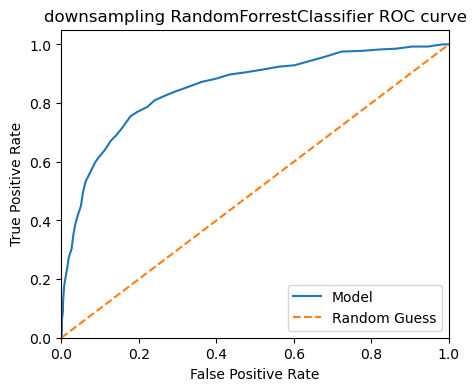

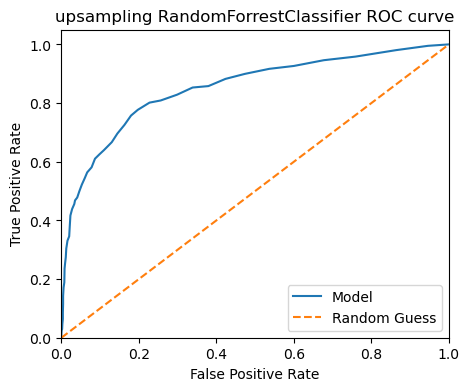

In [51]:
# Plot the AuC-ROC curve for the top 2 models
for i, row in results.iterrows():
    model = row['model']
    probabilities_valid = model.predict_proba(features_valid)[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{row['method']} {row['algorithm']} ROC curve")
    plt.legend()
    plt.show()

Because there is significantly better performance for the downsampling method with the Random Forrest Classifier, we will drop the rest of the models from the results df.

In an attempt to further improve the F1 and AUC ROC scores, we will iterate over a range of thresholds (from 0 to 1, at .02 intervals).

# Adjust Threshold

In [52]:
results = results.head(1)

results = find_threshold(results, features_valid, target_valid)

display(results)

,f1_score,auc_roc,model,params,algorithm,method,threshold
0,0.619209,0.772028,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 50, 'cr...",RandomForrestClassifier,downsampling,0.54
1,0.618047,0.758948,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 50, 'cr...",RandomForrestClassifier,downsampling,0.58
2,0.616751,0.754766,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 50, 'cr...",RandomForrestClassifier,downsampling,0.60


A threshold value of .54 returns the best f1 score, while a threshold of .50 returns the best AUC ROC score. In this case we will prioritize the F1 score and select the model with the best F1 as our best model for final testing.

In [53]:
best_result = results.iloc[0]

In [54]:
display(best_result)

f1_score                                              0.619209
auc_roc                                               0.772028
model        (DecisionTreeClassifier(max_features='sqrt', r...
params       {'class_weight': None, 'n_estimators': 50, 'cr...
algorithm                              RandomForrestClassifier
method                                            downsampling
threshold                                                 0.54
Name: 0, dtype: object

# Final Test

In [55]:
# Concat the training and validation data
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

# Downsample the training data
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3, random_state)

# Train the model on the downsampled data
model = best_result['model']
model.fit(features_downsampled, target_downsampled)

# Predict the probabilities of the positive class
probabilities_one_test = model.predict_proba(features_test)[:, 1]

# Set the threshold
threshold = best_result['threshold']
predictions_test = probabilities_one_test > threshold

# Calculate the f1 score
f1 = f1_score(target_test, predictions_test)
# Calculate the auc_roc score
auc_roc = roc_auc_score(target_test, predictions_test)
# Calculate the accuracy score
accuracy = model.score(features_test, target_test)

print(f"F1 Score: {f1}")
print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy Score: {accuracy}")


F1 Score: 0.6118192352259559
AUC-ROC Score: 0.7640606708403318
Accuracy Score: 0.8095


# Conclusion

In the task for creating a model capable of predicting Beta Bank customer churn with an f1 score of at least 0.59, three machine learning algorithms were tested (Decision Tree Classifier, Random Forrest Classifier, and Logistic Regression) using three different target class balancing methods ('weight_class'='balanced' argument, upsampling the minority class by 3x, and downsampling the majority class by 0.3x). 

The optimal method for balancing the classes was the downsampling by 0.3x method.  
The best Machine Learning algorithm was the Random Forrest Classifier with the parameters:  
> `{'class_weight': None, 'n_estimators': 500, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}`
The optimal threshold for this model and method was 0.54

## Results on the test dataset
F1 Score: 0.62  
AUC-ROC Score: 0.77  
Accuracy Score: 0.82